This is a tutorial that demonstrates a cross-correlation-based grid search for the underlying pose of a known structure. The idea of the search follows `cisTEM`'s 2D template matching program.

This is also a tutorial for using `cryojax`'s grid search API. In `cryojax.inference`, the function `run_grid_search` provides a flexible API for minimizing a loss function with grid search, while the abstract interface `AbstractGridSearchMethod` provides a way to extend the API. See the documentation for more information.

*Reference*:

- Lucas, Bronwyn A., et al. "Locating macromolecular assemblies in cells by 2D template matching with cisTEM." Elife 10 (2021): e68946.*

In [1]:
import equinox as eqx

import cryojax.simulator as cxs

In [2]:
# Plotting imports and function definitions
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable


def plot_image(image, fig, ax, cmap="gray", label=None, **kwargs):
    im = ax.imshow(image, cmap=cmap, origin="lower", **kwargs)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im, cax=cax)
    if label is not None:
        ax.set(title=label)
    return fig, ax

First, load the template. This template happens to be generated from cisTEM.

!!! note 
    The cisTEM scattering potential has been modified slightly because at the time of writing this, `cryojax` scattering potentials have different conventions than `cisTEM`'s. In particular, the `cisTEM` scattering potential was multiplied by a factor of $4 \pi /(\textrm{voxel size} \times \textrm{wavelength})$.

In [3]:
from cryojax.io import read_array_with_spacing_from_mrc


# First, load the template. This template happens to be generated from cisTEM
filename = "./data/ribosome_4ug0_scattering_potential_from_cistem.mrc"
template, voxel_size = read_array_with_spacing_from_mrc(filename)
potential = cxs.FourierVoxelGridPotential.from_real_voxel_grid(
    template, voxel_size, pad_scale=1.5
)

Now, load a particle stack on which to run the grid search. The particle stack will be loaded from a STAR file with the `RelionDataset` interface. See the [Read a particle stack](https://mjo22.github.io/cryojax/examples/read-dataset/) tutorial for more information.

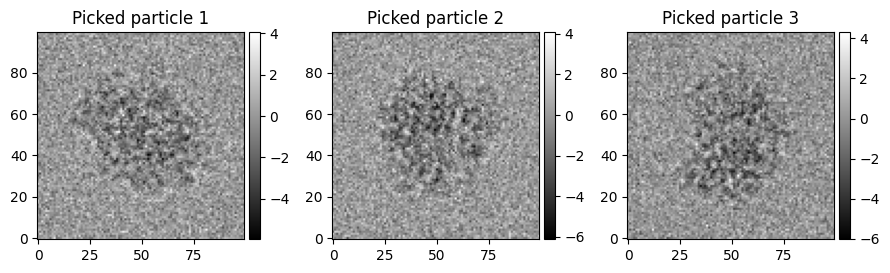

In [4]:
import jax

from cryojax.data import RelionDataset
from cryojax.image import normalize_image, rfftn


@jax.vmap
def normalize_image_stack(image):
    """Normalize a stack of images to have mean 0 and std 1."""
    return normalize_image(image, is_real=True)


# Load the dataset and index three particles in this dataset
make_config_fn = lambda shape, pixel_size, voltage_in_kilovolts: cxs.InstrumentConfig(
    shape, pixel_size, voltage_in_kilovolts, padded_shape=potential.shape[0:2]
)
dataset = RelionDataset(
    path_to_starfile="./data/ribosome_4ug0_particles.star",
    path_to_relion_project="./",
    make_instrument_config_fn=make_config_fn,
)
particle_stack = dataset[:3]
# Create a normalized image stack in fourier space
fourier_image_stack = rfftn(
    normalize_image_stack(particle_stack.image_stack), axes=(1, 2)
)
# Plot images
n_images = particle_stack.image_stack.shape[0]
fig, axes = plt.subplots(figsize=(3 * n_images, 3), ncols=n_images)
[
    plot_image(
        particle_stack.image_stack[i],
        fig,
        axes[i],
        label=f"Picked particle {i+1}",
    )
    for i in range(n_images)
]
plt.tight_layout()

Now, build the grid points in orientational space on which to search. This is done by vmapping over the `SO3.sample_uniform` method, which randomly and uniformly samples quaternions. 

In [5]:
from functools import partial

import equinox.internal as eqxi
import jax

from cryojax.rotations import SO3


@partial(eqx.filter_vmap, out_axes=eqxi.if_mapped(axis=0))
def make_pose_grid(key):
    """Create a grid of poses, where the grid is represented as
    a pytree (here, a `QuaternionPose`).
    """
    return cxs.QuaternionPose.from_rotation(SO3.sample_uniform(key))


# Create the grid
number_of_poses = 100_000
keys = jax.random.split(jax.random.PRNGKey(0), number_of_poses)
pose_grid = make_pose_grid(keys)

Now, finish building the `cryojax` model.

In [6]:
# ... create the structural ensemble
structural_ensemble = cxs.SingleStructureEnsemble(
    conformational_space=potential, pose=pose_grid
)
# ... now the scattering theory
transfer_theory = cxs.ContrastTransferTheory(particle_stack.ctf)
potential_integrator = cxs.FourierSliceExtraction(interpolation_order=1)
scattering_theory = cxs.WeakPhaseScatteringTheory(
    structural_ensemble, potential_integrator, transfer_theory
)
# ... and finally the imaging pipeline.
imaging_pipeline = cxs.ContrastImagingPipeline(
    particle_stack.instrument_config, scattering_theory
)

Notice we are doing something that may seem a little odd for those new to JAX---we are building an `imaging_pipeline` that has the grid of poses loaded into it. Hopefully the reason for doing this will become clear, however, note that this is just one possible pattern for writing a script, and people should create a workflow that works best for them!

It's time now to define the cross-correlation loss.

!!! info

    Before proceeding, its important to define how exactly the
    `cryojax` grid search tool defines a grid. For the grid search,
    the grid is an arbitrary pytree whose leaves are JAX arrays whose
    leading dimension indexes a set grid points. The entire grid is
    then the cartesian product of the grid points of all of its leaves.
    `cryojax` calls this a `tree_grid`.

In [14]:
import jax.numpy as jnp

import cryojax as cx
from cryojax.image import irfftn


# Grab an `equinox` filter specification where the CTF parameters
# have a batch dimension. These parameters are those not in the RELION
# optics group.
per_particle_filter_spec = cx.get_filter_spec(
    imaging_pipeline,
    lambda p: (
        p.scattering_theory.transfer_theory.ctf.defocus_in_angstroms,
        p.scattering_theory.transfer_theory.ctf.astigmatism_in_angstroms,
        p.scattering_theory.transfer_theory.ctf.astigmatism_angle,
        p.scattering_theory.transfer_theory.ctf.phase_shift,
    ),
)


@partial(cx.filter_vmap_with_spec, filter_spec=per_particle_filter_spec, in_axes=(0, 0))
def cross_correlation(pipeline, fourier_observed_image):
    """Compute the cross-correlation, batched over images in the `fourier_image_stack`,
    and per-particle parameters in the `pipeline`.
    """
    fourier_simulated_image = pipeline.render(get_real=False)
    return irfftn(
        fourier_observed_image * jnp.conj(fourier_simulated_image),
        s=pipeline.instrument_config.shape,
    ) / jnp.sqrt(pipeline.instrument_config.n_pixels)


@eqx.filter_jit
def objective_function(pipeline_at_grid_point, args):
    """The objective function for the grid search.

    Because the grid search tries to minimize a loss, the
    the object function is the negative cross correlation.

    Also, note the particular form of the function arguments.
    See `cryojax.inference.run_grid_search` for more information.
    """
    (
        pipeline_not_at_grid_point_vmap,
        pipeline_not_at_grid_point_no_vmap,
        fourier_observed_image_stack,
    ) = args
    pipeline_not_at_grid_point = eqx.combine(
        pipeline_not_at_grid_point_vmap, pipeline_not_at_grid_point_no_vmap
    )
    pipeline = eqx.combine(pipeline_at_grid_point, pipeline_not_at_grid_point)

    return -cross_correlation(pipeline, fourier_observed_image_stack)


@partial(eqx.filter_vmap, in_axes=(None, (0, None)))
def simulate_fourier_image_stack(pipeline_at_grid_point, args):
    """Simulate an image given a particular grid point."""
    pipeline_not_at_grid_point_vmap, pipeline_not_at_grid_point_no_vmap = args
    pipeline_not_at_grid_point = eqx.combine(
        pipeline_not_at_grid_point_vmap, pipeline_not_at_grid_point_no_vmap
    )
    pipeline = eqx.combine(pipeline_at_grid_point, pipeline_not_at_grid_point)

    return pipeline.render(get_real=False)

Now, we have to break up the `imaging_pipeline` into pieces using `equinox.partition`, so that we may smoothly pass through jit/vmap boundaries bfeore recombining pieces using `equinox.combine`. See the [Simulate a batch of images](https://mjo22.github.io/cryojax/examples/simulate-micrograph/) tutorial for an introduction to pytree manipulation with `equinox`.

In [15]:
# Get a specification for where the grid points are
tree_grid_filter_spec = cx.get_filter_spec(
    imaging_pipeline, lambda p: p.scattering_theory.structural_ensemble.pose.wxyz
)
# ... split up the `imaging_pipeline` into grid points and non-grid points
pipeline_tree_grid, pipeline_non_tree_grid = eqx.partition(
    imaging_pipeline, tree_grid_filter_spec
)
# ... and again into per-particle parameters and non-per-particle parameters
per_particle_pipeline, non_per_particle_pipeline = eqx.partition(
    pipeline_non_tree_grid, per_particle_filter_spec
)

We are almost ready to run the search. Before running, generate an image at a particular grid point to make sure simulated images look okay. This will involve using the grid manipulation utilities in `cryojax`, `tree_grid_take` and `tree_grid_unravel_index` (yes, like `numpy.take` and `numpy.unravel_index`).

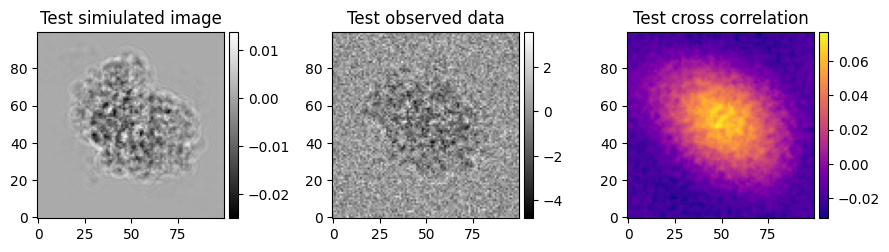

In [16]:
from cryojax.inference import tree_grid_take, tree_grid_unravel_index


# Grab the first grid point
test_pipeline_grid_point = tree_grid_take(
    pipeline_tree_grid, tree_grid_unravel_index(0, pipeline_tree_grid)
)
# ... simulate a stack of images at each particle's parameters at this grid point
test_simulated_fourier_image_stack = simulate_fourier_image_stack(
    test_pipeline_grid_point, (per_particle_pipeline, non_per_particle_pipeline)
)
# ... compute the negative cross-correlation between the simulated and observed images
neg_cc = objective_function(
    test_pipeline_grid_point,
    (per_particle_pipeline, non_per_particle_pipeline, fourier_image_stack),
)

fig, axes = plt.subplots(figsize=(9, 3.5), ncols=3)
plot_image(
    irfftn(
        test_simulated_fourier_image_stack[0],
        s=imaging_pipeline.instrument_config.shape,
    ),
    fig,
    axes[0],
    label="Test simiulated image",
)
plot_image(
    irfftn(fourier_image_stack[0], s=imaging_pipeline.instrument_config.shape),
    fig,
    axes[1],
    label="Test observed data",
)
plot_image(
    -neg_cc[0],
    fig,
    axes[2],
    label="Test cross correlation",
    cmap="plasma",
)
plt.tight_layout()

Finally, run the grid search.

!!! info

    The function `run_grid_search` runs the search loop, while the `AbstractGridSearchMethod`
    tells the search loop what to do. The `AbstractGridSearchMethod` below is the `MinimumSearchMethod`,
    which simply stores the minimum value of the loss function (more specifically, it is an *elementwise* minimum, since the cross-correlation function returns a grid of loss-function evaluations).

In [17]:
import math

from cryojax.inference import MinimumSearchMethod, run_grid_search, tree_grid_shape


# Choose the search method
method = MinimumSearchMethod(batch_size=100)
# ... compute the number of iterations of the search in order to configure the progress
# bar.
n_iterations = math.prod(tree_grid_shape(pipeline_tree_grid)) // method.batch_size  # type: ignore
# ... run the search!
result = run_grid_search(
    objective_function,
    method,
    pipeline_tree_grid,
    args=(per_particle_pipeline, non_per_particle_pipeline, fourier_image_stack),
    progress_bar=True,
    total_progress_bar_updates=20,
)

  0%|          | 0/1000 [00:00<?, ?it/s]

Great! Let's see how the search did. First we can plot the maximum cross-correlation value per pixel (or, per translation) in the cross-correlation grid.

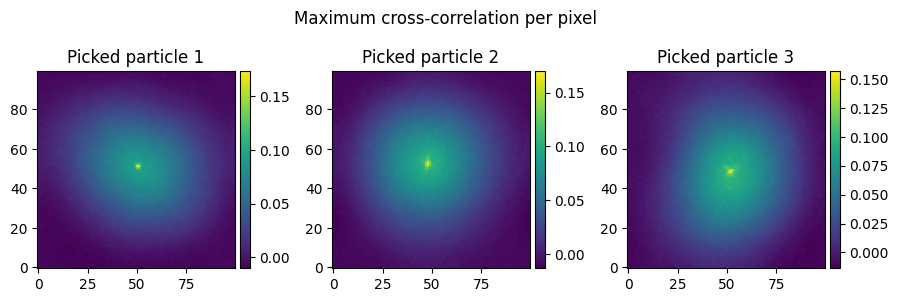

In [18]:
n_images = particle_stack.image_stack.shape[0]
fig, axes = plt.subplots(figsize=(3 * n_images, 3), ncols=n_images)
fig.suptitle("Maximum cross-correlation per pixel")
[
    plot_image(
        -result.state.current_minimum_eval[i],
        fig,
        axes[i],
        cmap="viridis",
        label=f"Picked particle {i+1}",
    )
    for i in range(n_images)
]
plt.tight_layout()

Not bad! To know if we're right, it would be good to take the peak cross-correlation and plot the image that corresponds to those parameters. To do so, define some functions to extract the parameters from the peak, simulate an image from those parameters, and also compute the corresponding cross-correlation grid.

In [19]:
@partial(eqx.filter_vmap, in_axes=(0, (None, 0, None)), out_axes=eqxi.if_mapped(0))
def extract_solution_at_minimum(final_state, args):
    pipeline_grid, per_particle_pipeline, non_per_particle_pipeline = args
    image_index_at_minimum = jnp.argmin(final_state.current_minimum_eval.ravel())
    raveled_grid_index_at_minimum = final_state.current_best_raveled_index.ravel()[
        image_index_at_minimum
    ]
    tree_grid_index_at_minimum = tree_grid_unravel_index(
        raveled_grid_index_at_minimum, pipeline_grid
    )
    solution = tree_grid_take(pipeline_grid, tree_grid_index_at_minimum)
    return eqx.combine(
        solution, eqx.combine(per_particle_pipeline, non_per_particle_pipeline)
    )


solution_filter_spec = jax.tree_util.tree_map(
    lambda x, y: x or y, per_particle_filter_spec, tree_grid_filter_spec
)
solution_pipeline = extract_solution_at_minimum(
    result.state, (pipeline_tree_grid, per_particle_pipeline, non_per_particle_pipeline)
)


@partial(cx.filter_vmap_with_spec, filter_spec=solution_filter_spec)
def simulate_solution_image_stack(pipeline):
    return pipeline.render()


@partial(cx.filter_vmap_with_spec, filter_spec=solution_filter_spec, in_axes=(0, 0))
def compute_solution_cross_correlation(pipeline, fourier_observed_image):
    fourier_simulated_image = pipeline.render(get_real=False)
    return (
        irfftn(
            fourier_observed_image * jnp.conj(fourier_simulated_image),
            s=pipeline.instrument_config.shape,
        )
        / pipeline.instrument_config.n_pixels
    )

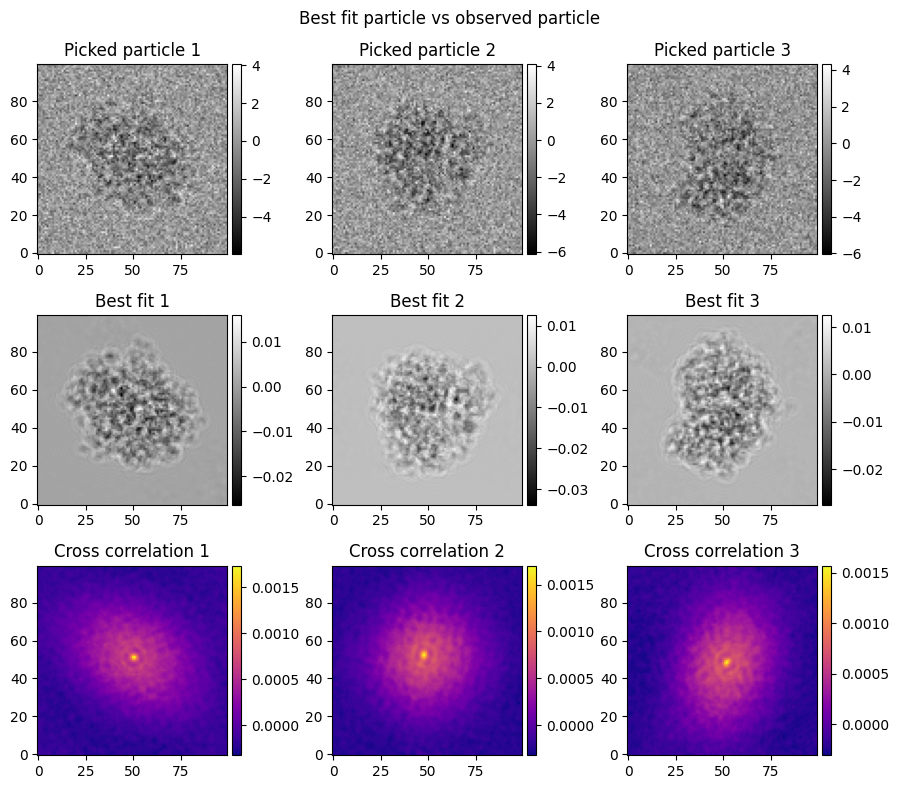

In [20]:
# Simulate the solution and compute its corresponding cross-correlation
n_images = particle_stack.image_stack.shape[0]
solution_image_stack = simulate_solution_image_stack(solution_pipeline)
solution_cross_correlation = compute_solution_cross_correlation(
    solution_pipeline, fourier_image_stack
)

fig, axes = plt.subplots(figsize=(3 * n_images, 8), ncols=n_images, nrows=3)
fig.suptitle("Best fit particle vs observed particle")
for i in range(n_images):
    observed = particle_stack.image_stack[i]
    simulated = solution_image_stack[i]
    cc = solution_cross_correlation[i]
    plot_image(observed, fig, axes[0, i], label=f"Picked particle {i+1}")
    plot_image(simulated, fig, axes[1, i], label=f"Best fit {i+1}")
    plot_image(cc, fig, axes[2, i], label=f"Cross correlation {i+1}", cmap="plasma")
plt.tight_layout()